# 💳 Credit Card Fraud Detection Project

This notebook implements a fraud detection model using a public dataset from Kaggle.

**Dataset**: [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

## 📌 Objectives:
- Preprocess the dataset
- Explore data visually
- Handle class imbalance
- Train ML models
- Evaluate results
- Export for Power BI

In [13]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [14]:
# 📂 Load Dataset
df = pd.read_csv('/Users/bharathhpatibandla/Downloads/Credit Card project/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


/var/folders/bw/xsh6wy757z33r1hvsxxw01hc0000gn/T/ipykernel_52971/3770729716.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/bw/xsh6wy757z33r1hvsxxw01hc0000gn/T/ipykernel_52971/3770729716.py:32: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


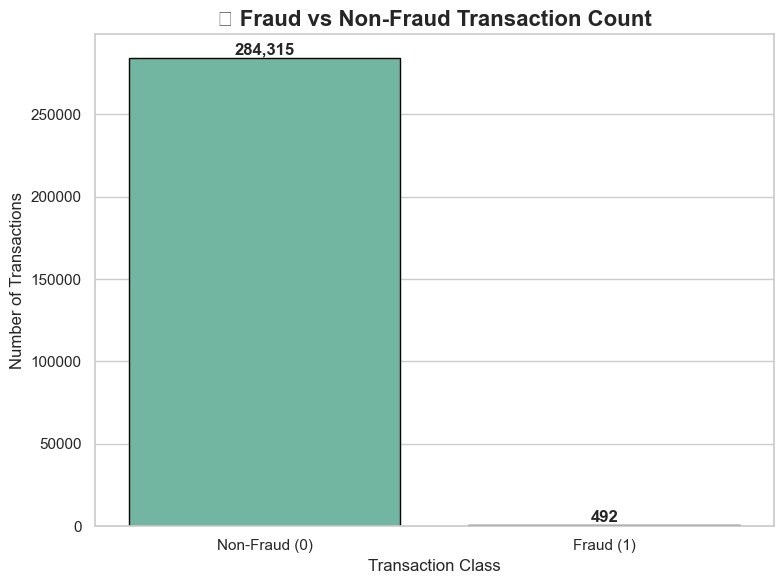

In [15]:
# 📊 Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme for fancy aesthetics
sns.set_theme(style="whitegrid")

# Get fraud class distribution
class_counts = df['Class'].value_counts()
labels = ['Non-Fraud (0)', 'Fraud (1)']
colors = ['#66c2a5', '#fc8d62']

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=labels,
    y=class_counts.values,
    palette=colors,
    edgecolor='black'
)

# Add count labels on bars
for i, count in enumerate(class_counts.values):
    ax.text(i, count + 500, f"{count:,}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Titles and labels
plt.title('💳 Fraud vs Non-Fraud Transaction Count', fontsize=16, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Transaction Class', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


In [16]:
# ⚙️ Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Create a copy to avoid modifying the original DataFrame
df_alt = df.copy()

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Scale 'Amount' and 'Time' columns
df_alt['normalized_amount'] = minmax_scaler.fit_transform(df_alt['Amount'].values.reshape(-1, 1))
df_alt['normalized_time'] = minmax_scaler.fit_transform(df_alt['Time'].values.reshape(-1, 1))

# Drop original columns
df_alt.drop(['Time', 'Amount'], axis=1, inplace=True)

# Reorder columns for convenience
columns = ['normalized_time', 'normalized_amount'] + [col for col in df_alt.columns if col not in ['normalized_time', 'normalized_amount', 'Class']] + ['Class']
df_alt = df_alt[columns]

# View final structure
df_alt.head()


,normalized_time,normalized_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.000000,0.005824,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,0.000000,0.000105,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,0.000006,0.014739,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.000006,0.004807,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.000012,0.002724,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [17]:
# ⚖️ Handle Class Imbalance
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [18]:
# 🤖 Train Model
model = XGBClassifier()
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56842    22]
 [   15    83]]


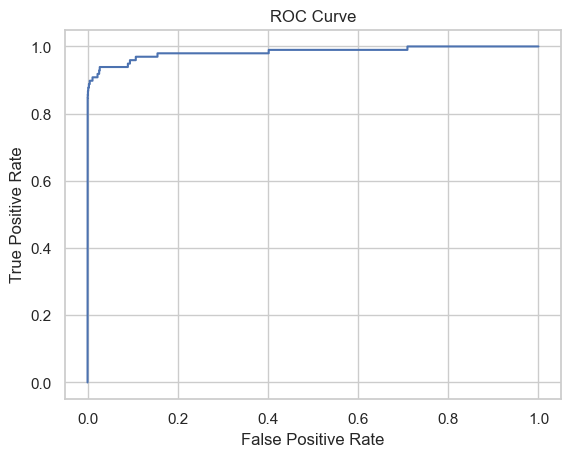

AUC Score: 0.9831145633548861


In [19]:
# 📈 ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print("AUC Score:", roc_auc_score(y_test, y_proba))

In [22]:
# 📤 Export for Power BI
# Ensure all required variables are defined and available
X_test = X_test.copy() if 'X_test' in locals() else X_test  # Ensure X_test is defined
X_test['actual_class'] = y_test  # y_test is defined in CELL INDEX: 5
X_test['predicted_class'] = y_pred  # y_pred is defined in CELL INDEX: 6
X_test['predicted_proba'] = y_proba  # y_proba is defined in CELL INDEX: 7
X_test.to_csv('fraud_predictions.csv', index=False)